In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import subprocess
import sys
import os

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install required packages
try:
    import torch
except ImportError:
    print("Installing PyTorch...")
    install_package("torch")
    import torch

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import deque
import random

# Sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                           roc_curve, auc, accuracy_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.datasets import make_classification

# PyTorch imports
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [3]:
df=pd.read_csv('/content/cicddos2019_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['Class'].value_counts()}")

df['Class'] = df['Class'].map({'Benign': 0, 'Attack': 1})

# Define features and target
features = [col for col in df.columns if col != 'Class']
target = 'Class'

print(f"Total features before processing: {len(features)}")
print(f"Dataset columns: {list(df.columns)}")

# STEP 1: Identify numerical and categorical columns
print("\n" + "="*60)
print("STEP 1: IDENTIFYING COLUMN TYPES")
print("="*60)

# Separate numerical and categorical data from feature columns only
num_cols = df[features].select_dtypes(include=['number']).columns.tolist()
cat_cols = df[features].select_dtypes(exclude=['number']).columns.tolist()

print(f"Numerical columns ({len(num_cols)}): {num_cols[:5]}...")  # Show first 5
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

# STEP 2: Handle missing values BEFORE scaling/encoding
print("\n" + "="*60)
print("STEP 2: HANDLING MISSING VALUES")
print("="*60)

# Handle missing values in numerical columns
missing_num_info = []
for col in num_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        missing_num_info.append(f"{col}: {missing_count} missing values")
        df[col] = df[col].fillna(df[col].mean())

if missing_num_info:
    print("Missing values in numerical columns (filled with mean):")
    for info in missing_num_info:
        print(f"  - {info}")
else:
    print("No missing values in numerical columns")

# Handle missing values in categorical columns
missing_cat_info = []
for col in cat_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        missing_cat_info.append(f"{col}: {missing_count} missing values (filled with '{mode_val}')")
        df[col] = df[col].fillna(mode_val)

if missing_cat_info:
    print("Missing values in categorical columns:")
    for info in missing_cat_info:
        print(f"  - {info}")
else:
    print("No missing values in categorical columns")

# STEP 3: Scale numerical columns
print("\n" + "="*60)
print("STEP 3: SCALING NUMERICAL COLUMNS")
print("="*60)

if num_cols:
    print(f"Scaling {len(num_cols)} numerical columns...")

    # Show statistics before scaling (first 5 columns)
    print("Statistics before scaling (first 5 numerical columns):")
    for col in num_cols[:5]:
        mean_val = df[col].mean()
        std_val = df[col].std()
        min_val = df[col].min()
        max_val = df[col].max()
        print(f"  {col}: mean={mean_val:.3f}, std={std_val:.3f}, min={min_val:.3f}, max={max_val:.3f}")

    # Apply StandardScaler
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

    # Show statistics after scaling
    print("Statistics after scaling (first 5 numerical columns):")
    for col in num_cols[:5]:
        mean_val = df_scaled[col].mean()
        std_val = df_scaled[col].std()
        min_val = df_scaled[col].min()
        max_val = df_scaled[col].max()
        print(f"  {col}: mean={mean_val:.3f}, std={std_val:.3f}, min={min_val:.3f}, max={max_val:.3f}")

    df = df_scaled
    print("✓ Numerical columns scaled successfully")
else:
    print("No numerical columns to scale")

# STEP 4: Encode categorical columns
print("\n" + "="*60)
print("STEP 4: ENCODING CATEGORICAL COLUMNS")
print("="*60)

if cat_cols:
    print(f"Processing {len(cat_cols)} categorical columns...")

    # Analyze cardinality of categorical columns
    high_cardinality_cols = []
    low_cardinality_cols = []

    for col in cat_cols:
        unique_count = df[col].nunique()
        print(f"  {col}: {unique_count} unique values")

        if unique_count > 50:  # Threshold for high cardinality
            high_cardinality_cols.append(col)
        else:
            low_cardinality_cols.append(col)

    print(f"\nHigh cardinality columns (>50 unique values): {high_cardinality_cols}")
    print(f"Low cardinality columns (≤50 unique values): {low_cardinality_cols}")

    # Apply Label Encoding to high cardinality columns
    if high_cardinality_cols:
        print(f"\nApplying Label Encoding to {len(high_cardinality_cols)} high cardinality columns...")
        label_encoders = {}

        for col in high_cardinality_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            print(f"  ✓ {col}: encoded to values 0-{df[col].max()}")

    # Apply One-Hot Encoding to low cardinality columns
    if low_cardinality_cols:
        print(f"\nApplying One-Hot Encoding to {len(low_cardinality_cols)} low cardinality columns...")

        # Ensure columns still exist in the DataFrame
        low_cardinality_cols = [col for col in low_cardinality_cols if col in df.columns]
        if not low_cardinality_cols:
            print("  Warning: No low cardinality columns found in DataFrame at this stage.")
        else:
            # Get dummy variables
            df_dummies = pd.get_dummies(df[low_cardinality_cols], drop_first=True)
            print(f"  Created {len(df_dummies.columns)} dummy variables")

            # Drop original categorical columns and add dummy variables
            df = df.drop(columns=low_cardinality_cols)
            df = pd.concat([df, df_dummies], axis=1)

            print("  ✓ One-hot encoding completed")
            print(f"  New dummy columns: {list(df_dummies.columns)[:5]}...")  # Show first 5


# STEP 5: Finalize processed dataset
print("\n" + "="*60)
print("STEP 5: FINALIZING PROCESSED DATASET")
print("="*60)

# Update features list after all transformations
df_processed = df.copy()
features = [col for col in df_processed.columns if col != target]

print(f"Final number of features: {len(features)}")
print(f"Final dataset shape: {df_processed.shape}")

# Ensure all feature columns are numeric
non_numeric_features = []
for col in features:
    if not pd.api.types.is_numeric_dtype(df_processed[col]):
        non_numeric_features.append(col)
        # Convert to numeric, coercing errors to NaN
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        # Fill any NaNs that might have been introduced
        if df_processed[col].isnull().any():
            df_processed[col] = df_processed[col].fillna(df_processed[col].mean())

if non_numeric_features:
    print(f"Warning: Had to convert {len(non_numeric_features)} columns to numeric: {non_numeric_features}")
else:
    print("✓ All feature columns are numeric")

# Verify data types
print("\nFinal data types:")
print(f"  Numerical features: {len([col for col in features if pd.api.types.is_numeric_dtype(df_processed[col])])}")
print(f"  Target column: {df_processed[target].dtype}")

print("✓ Data preprocessing completed successfully!")

# STEP 6: Remove duplicates
print("\n" + "="*60)
print("STEP 6: REMOVING DUPLICATES")
print("="*60)

initial_shape = df_processed.shape[0]
df_processed = df_processed.drop_duplicates()
removed_duplicates = initial_shape - df_processed.shape[0]
print(f"Removed {removed_duplicates} duplicate rows ({removed_duplicates/initial_shape*100:.1f}% of data)")
print(f"Final dataset shape after duplicate removal: {df_processed.shape}")

# STEP 7: Handle outliers using IQR method
print("\n" + "="*60)
print("STEP 7: HANDLING OUTLIERS")
print("="*60)

def handle_outliers_iqr(df_in, col_name):
    """Handle outliers using Interquartile Range (IQR) method"""
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers before handling
    outliers_count = ((df_in[col_name] < lower) | (df_in[col_name] > upper)).sum()

    df_out = df_in.copy()
    df_out.loc[df_out[col_name] < lower, col_name] = lower
    df_out.loc[df_out[col_name] > upper, col_name] = upper

    return df_out, outliers_count

print("Handling outliers for numerical features...")
clean_df = df_processed.copy()
total_outliers = 0

# Only apply outlier handling to truly numerical features
numerical_features = [col for col in features if col in num_cols or
                     (col not in num_cols and not any(col.startswith(f"{cat_col}_") for cat_col in cat_cols if cat_cols))]

print(f"Applying outlier handling to {len(numerical_features)} numerical features...")

for col in numerical_features[:10]:  # Limit to first 10 to avoid too much output
    if col in clean_df.columns:
        clean_df, outliers_count = handle_outliers_iqr(clean_df, col)
        if outliers_count > 0:
            total_outliers += outliers_count
            print(f"  {col}: {outliers_count} outliers handled")

if total_outliers > 0:
    print(f"✓ Total outliers handled: {total_outliers}")
else:
    print("✓ No significant outliers found")
print("Data preprocessing completed!")

Dataset shape: (431371, 80)
Target distribution:
Class
Attack    333540
Benign     97831
Name: count, dtype: int64
Total features before processing: 79
Dataset columns: ['Unnamed: 0', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std'

Generating visualizations...


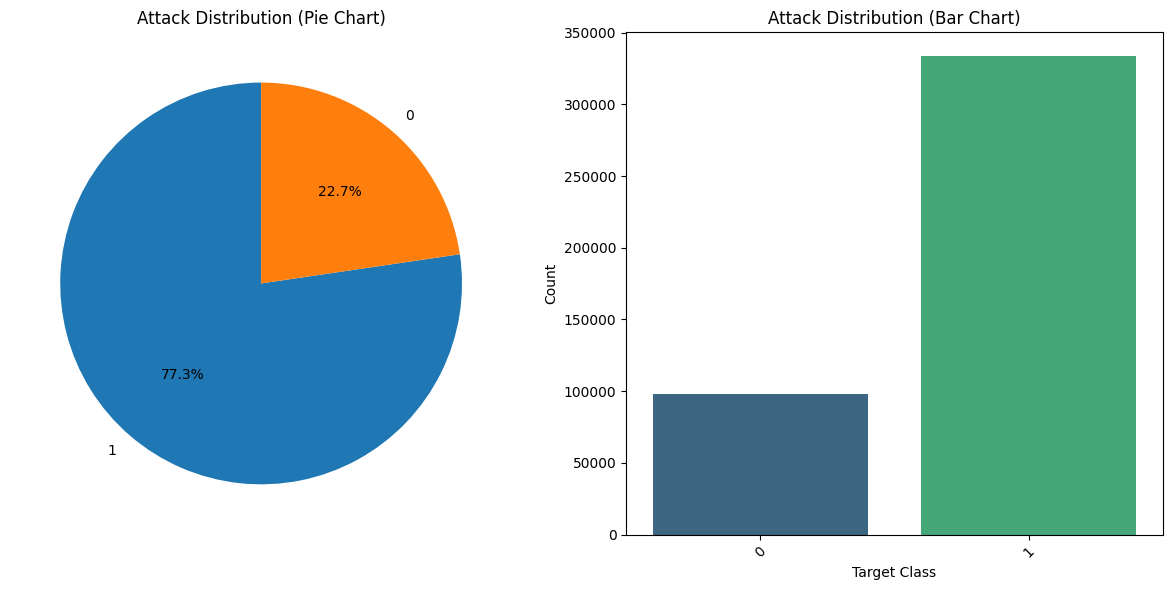

Skipping correlation matrix visualization (too many features: 95)
Preparing data for machine learning...
Training set shape: (345096, 95)
Test set shape: (86275, 95)
Number of classes: 2
Class labels: [0 1]


In [4]:
# Data Visualization and Analysis
print("Generating visualizations...")

# 1. Attack Distribution Plot
plt.figure(figsize=(12, 6))

# Plot 1: Pie chart
plt.subplot(1, 2, 1)
attack_counts = clean_df[target].value_counts()
plt.pie(attack_counts.values, labels=attack_counts.index,
        autopct='%1.1f%%', startangle=90)
plt.title('Attack Distribution (Pie Chart)')

# Plot 2: Bar plot
plt.subplot(1, 2, 2)
sns.countplot(data=clean_df, x=target, palette='viridis')
plt.title('Attack Distribution (Bar Chart)')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Feature Importance (Correlation-based) - only for manageable number of features
if len(features) <= 20:
    plt.figure(figsize=(10, 8))
    correlation_matrix = clean_df[features + [target]].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, fmt=".2f")
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping correlation matrix visualization (too many features: {len(features)})")

# Data preparation for ML
print("Preparing data for machine learning...")

X = clean_df[features].values
y = clean_df[target].values

# Encode target labels to integers
le_target = LabelEncoder()
y = le_target.fit_transform(y)
n_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {n_classes}")
print(f"Class labels: {le_target.classes_}")

In [5]:
# Define Reinforcement Learning Environment
class NetworkTrafficEnvironment:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n_samples = len(X)
        self.current_idx = 0
        self.n_features = X.shape[1]
        self.n_classes = len(np.unique(y))

    def reset(self):
        self.current_idx = 0
        return self.get_state()

    def get_state(self):
        if self.current_idx < self.n_samples:
            return self.X[self.current_idx]
        return np.zeros(self.n_features)

    def step(self, action):
        if self.current_idx >= self.n_samples:
            return self.get_state(), 0, True, {}

        true_label = self.y[self.current_idx]
        reward = 1.0 if action == true_label else -1.0

        self.current_idx += 1
        done = self.current_idx >= self.n_samples

        next_state = self.get_state()
        return next_state, reward, done, {}

# Traditional Q-Learning Agent
class QLearningAgent:
    def __init__(self, n_actions, alpha=0.1, gamma=0.9, epsilon=1.0):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.q_table = {}  # Initialize q_table

    def get_q_values(self, state_idx):
        if state_idx not in self.q_table:
            self.q_table[state_idx] = np.zeros(self.n_actions)
        return self.q_table[state_idx]

    def choose_action(self, state_idx):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return np.argmax(self.get_q_values(state_idx))

    def update(self, state_idx, action, reward, next_state_idx, done):
        current_q = self.get_q_values(state_idx)[action]
        target = reward
        if not done:
            target += self.gamma * np.max(self.get_q_values(next_state_idx))

        self.q_table[state_idx][action] += self.alpha * (target - current_q)

    def decay_epsilon(self, decay_rate=0.995, min_epsilon=0.01):
        self.epsilon = max(min_epsilon, self.epsilon * decay_rate)


In [6]:
# Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, epsilon=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = gamma
        self.learning_rate = lr

        # Use GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Neural networks
        self.q_network = DQN(state_size, 128, action_size).to(self.device)
        self.target_network = DQN(state_size, 128, action_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Update target network
        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
      state = np.array(state, dtype=np.float32)
      next_state = np.array(next_state, dtype=np.float32)
      self.memory.append((state, action, reward, next_state, done))


    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        self.q_network.train()
        return torch.argmax(q_values).item()

    def replay(self, batch_size):
        batch = random.sample(self.memory, batch_size)

        states = torch.FloatTensor(np.array([np.array(e[0], dtype=np.float32) for e in batch])).to(self.device)
        actions = torch.LongTensor([e[1] for e in batch]).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor([e[2] for e in batch]).to(self.device)
        next_states = torch.FloatTensor(np.array([np.array(e[3], dtype=np.float32) for e in batch])).to(self.device)
        dones = torch.BoolTensor([e[4] for e in batch]).to(self.device)

        current_q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Training agents...
Using device: cpu
Episode 20/100
Q-Learning Reward: 90.00, Epsilon: 0.9046
DQN Reward: 9901.00, Epsilon: 0.0100
--------------------------------------------------
Episode 40/100
Q-Learning Reward: 198.00, Epsilon: 0.8183
DQN Reward: 9934.00, Epsilon: 0.0100
--------------------------------------------------
Episode 60/100
Q-Learning Reward: 316.00, Epsilon: 0.7403
DQN Reward: 9978.00, Epsilon: 0.0100
--------------------------------------------------
Episode 80/100
Q-Learning Reward: 320.00, Epsilon: 0.6696
DQN Reward: 9868.00, Epsilon: 0.0100
--------------------------------------------------
Episode 100/100
Q-Learning Reward: 406.00, Epsilon: 0.6058
DQN Reward: 9934.00, Epsilon: 0.0100
--------------------------------------------------


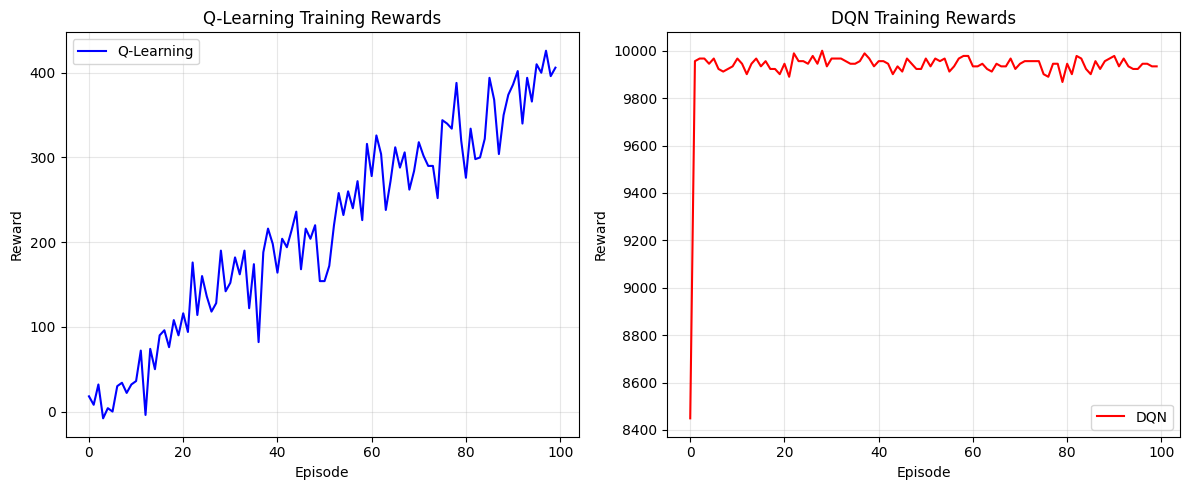

In [7]:
X_train = X_train.astype(np.float32)

# Training function
def train_agents():
    print("Training agents...")

    max_samples_q_learning = min(1000, len(X_train))
    X_train_q_subset = X_train[:max_samples_q_learning]
    y_train_q_subset = y_train[:max_samples_q_learning]

    env_q = NetworkTrafficEnvironment(X_train_q_subset, y_train_q_subset)
    q_agent = QLearningAgent(n_actions=n_classes)

    # DQN Agent
    dqn_agent = DQNAgent(state_size=X_train.shape[1], action_size=n_classes)

    # Training metrics
    q_rewards = []
    dqn_rewards = []
    episodes = 100  # Reduced for faster training

    for episode in range(episodes):
        # Train Q-Learning Agent
        state_q = env_q.reset()
        q_episode_reward = 0

        for step in range(len(X_train_q_subset)):
            state_idx = step
            action = q_agent.choose_action(state_idx)
            next_state_q, reward, done, _ = env_q.step(action)
            next_state_idx = step + 1

            q_agent.update(state_idx, action, reward, next_state_idx, done)
            q_episode_reward += reward

            if done:
                break

        q_agent.decay_epsilon()
        q_rewards.append(q_episode_reward)

        # Train DQN Agent
        dqn_episode_reward = 0
        for step in range(min(1000, len(X_train))):  # Limit for faster training
            state_dqn = X_train[step]
            action = dqn_agent.act(state_dqn)

            true_label = y_train[step]
            reward = 10.0 if action == true_label else -1.0

            next_state_dqn = X_train[(step + 1) % len(X_train)] if step < len(X_train) - 1 else np.zeros(X_train.shape[1])
            done = step == min(1000, len(X_train)) - 1

            dqn_agent.remember(state_dqn, action, reward, next_state_dqn, done)
            dqn_episode_reward += reward

            if len(dqn_agent.memory) > 100:
                dqn_agent.replay(32)


        # Update target network every 10 episodes
        if (episode + 1) % 10 == 0:
            dqn_agent.update_target_network()

        dqn_rewards.append(dqn_episode_reward)

        if (episode + 1) % 20 == 0:
            print(f"Episode {episode+1}/{episodes}")
            print(f"Q-Learning Reward: {q_episode_reward:.2f}, Epsilon: {q_agent.epsilon:.4f}")
            print(f"DQN Reward: {dqn_episode_reward:.2f}, Epsilon: {dqn_agent.epsilon:.4f}")
            print("-" * 50)

    return q_agent, dqn_agent, q_rewards, dqn_rewards

# Train the agents
q_agent, dqn_agent, q_rewards, dqn_rewards = train_agents()

# Plot training rewards
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(q_rewards, label='Q-Learning', color='blue')
plt.title('Q-Learning Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dqn_rewards, label='DQN', color='red')
plt.title('DQN Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Evaluating Q-Learning agent...
Evaluating DQN agent...
Q-Learning Accuracy: 0.6406
DQN Accuracy: 0.9944
Random Forest Accuracy: 0.9999


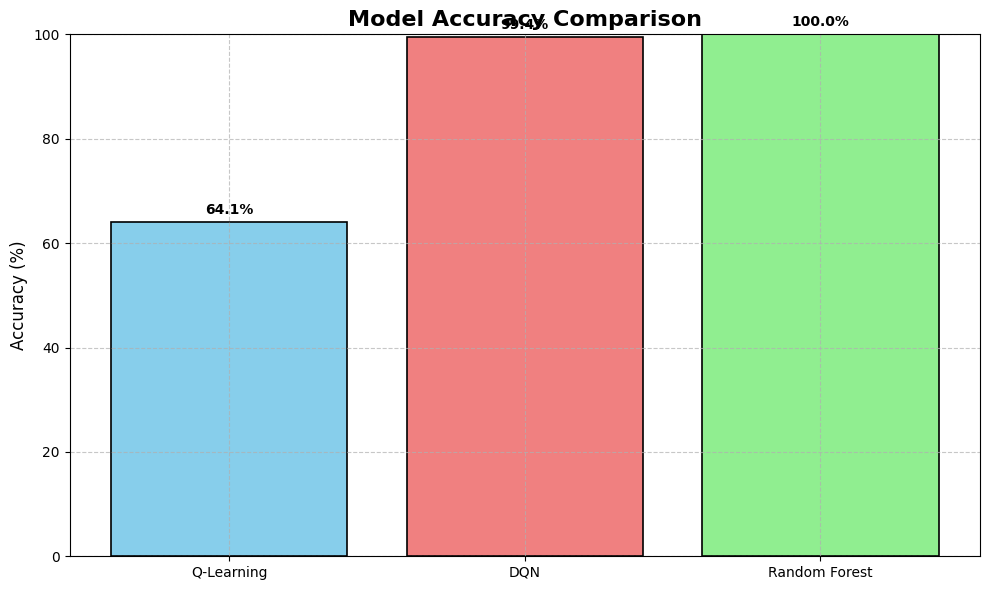

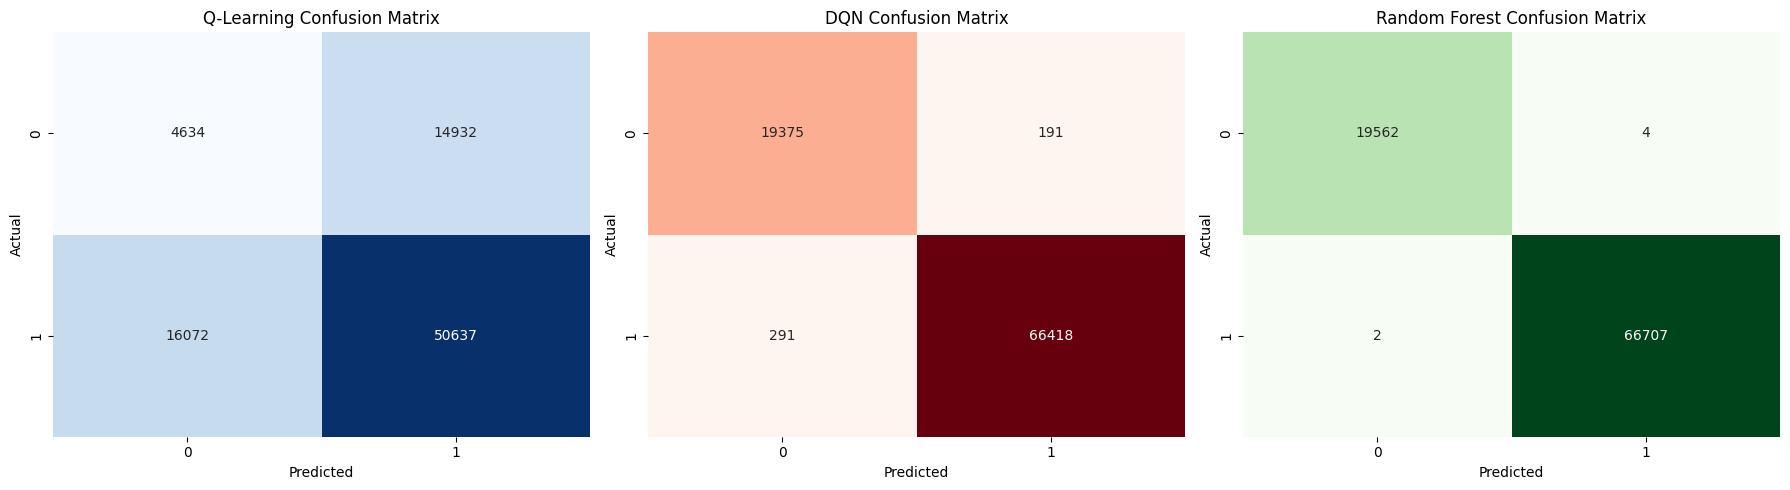


CLASSIFICATION REPORTS

Q-Learning Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.24      0.23     19566
           1       0.77      0.76      0.77     66709

    accuracy                           0.64     86275
   macro avg       0.50      0.50      0.50     86275
weighted avg       0.65      0.64      0.64     86275


DQN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19566
           1       1.00      1.00      1.00     66709

    accuracy                           0.99     86275
   macro avg       0.99      0.99      0.99     86275
weighted avg       0.99      0.99      0.99     86275


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19566
           1       1.00      1.00      1.00     66709

    accuracy                           1.00     86275
   

In [8]:
# Evaluation function
def evaluate_agent(agent, X_eval, y_eval, agent_type='Q-Learning'):
    print(f"Evaluating {agent_type} agent...")

    predictions = []
    X_eval = np.array([np.array(x, dtype=np.float32) for x in X_eval])

    if agent_type == 'Q-Learning':
        # Fixed evaluation for Q-Learning
        agent.epsilon = 0  # Set to greedy mode for evaluation
        for i in range(len(X_eval)):
            state_idx = i % len(agent.q_table) if len(agent.q_table) > 0 else 0
            if state_idx in agent.q_table:
                action = np.argmax(agent.get_q_values(state_idx))
            else:
                action = np.random.choice(agent.n_actions)
            predictions.append(action)
    else:  # DQN
        agent.epsilon = 0  # Set to greedy mode for evaluation
        for i in range(len(X_eval)):
            state = X_eval[i]
            action = agent.act(state)
            predictions.append(action)

    predictions = np.array(predictions)
    accuracy = accuracy_score(y_eval, predictions)

    return accuracy, predictions

# Evaluate both agents
q_accuracy, q_predictions = evaluate_agent(q_agent, X_test, y_test, 'Q-Learning')
dqn_accuracy, dqn_predictions = evaluate_agent(dqn_agent, X_test, y_test, 'DQN')

print(f"Q-Learning Accuracy: {q_accuracy:.4f}")
print(f"DQN Accuracy: {dqn_accuracy:.4f}")

# Comparison with Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Accuracy Comparison Plot
plt.figure(figsize=(10, 6))
methods = ['Q-Learning', 'DQN', 'Random Forest']
accuracies = [q_accuracy * 100, dqn_accuracy * 100, rf_accuracy * 100]
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = plt.bar(methods, accuracies, color=colors, edgecolor='black', linewidth=1.2)
plt.ylim(0, 100)
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Q-Learning Confusion Matrix
cm_q = confusion_matrix(y_test, q_predictions)
sns.heatmap(cm_q, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Q-Learning Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# DQN Confusion Matrix
cm_dqn = confusion_matrix(y_test, dqn_predictions)
sns.heatmap(cm_dqn, annot=True, fmt='d', cmap='Reds', ax=axes[1], cbar=False)
axes[1].set_title('DQN Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[2], cbar=False)
axes[2].set_title('Random Forest Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Print Classification Reports
print("\n" + "="*60)
print("CLASSIFICATION REPORTS")
print("="*60)

target_names = [str(cls) for cls in le_target.classes_]

print("\nQ-Learning Classification Report:")
print(classification_report(y_test, q_predictions, target_names=target_names, zero_division=0))

print("\nDQN Classification Report:")
print(classification_report(y_test, dqn_predictions, target_names=target_names, zero_division=0))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions, target_names=target_names, zero_division=0))

# Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Dataset Size: {len(clean_df)} samples")
print(f"Number of Features: {len(features)}")
print(f"Number of Classes: {n_classes}")
print(f"Test Set Size: {len(X_test)} samples")
print("\nModel Accuracies:")
print(f"  Q-Learning:    {q_accuracy:.4f} ({q_accuracy*100:.2f}%)")
print(f"  DQN:           {dqn_accuracy:.4f} ({dqn_accuracy*100:.2f}%)")
print(f"  Random Forest: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")

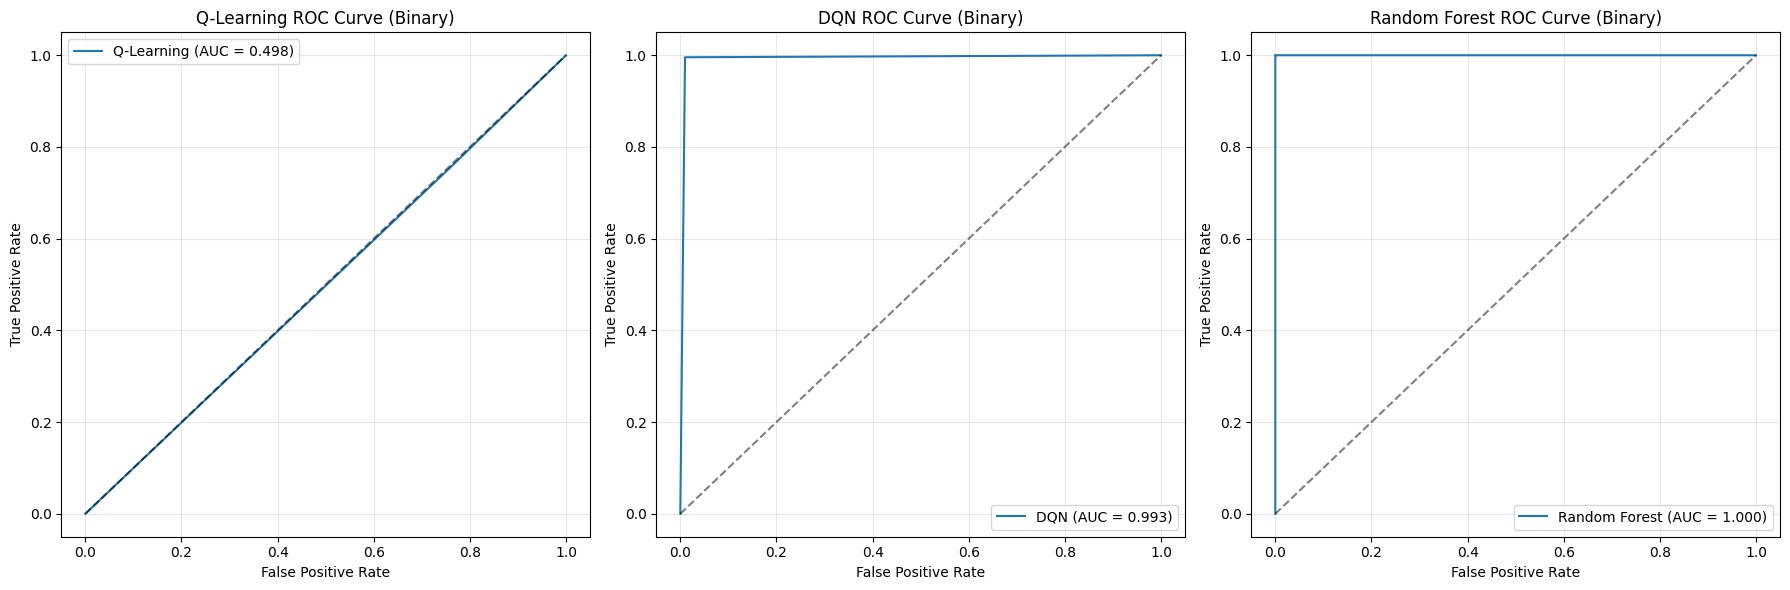


FINAL RESULTS SUMMARY
Dataset Size: 431371 samples
Number of Features: 95
Number of Classes: 2
Test Set Size: 86275 samples

Model Accuracies:
  Q-Learning:    0.6406 (64.06%)
  DQN:           0.9944 (99.44%)
  Random Forest: 0.9999 (99.99%)


In [9]:
# 6. ROC Curves (for multi-class)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

q_predictions_bin = label_binarize(q_predictions, classes=range(n_classes))
dqn_predictions_bin = label_binarize(dqn_predictions, classes=range(n_classes))

# For Random Forest, we can get probabilities directly
rf_probabilities = rf_model.predict_proba(X_test)

plt.figure(figsize=(18, 6))

# Plot ROC for Q-Learning
plt.subplot(1, 3, 1)
if n_classes > 2:
    for j in range(n_classes):
        if np.sum(y_test_bin[:, j]) > 0: # Check if class exists in test set
            fpr, tpr, _ = roc_curve(y_test_bin[:, j], q_predictions_bin[:, j])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {j} (AUC = {roc_auc:.3f})')
    plt.title('Q-Learning ROC Curves (Multi-class)')
else: # Binary
    fpr, tpr, _ = roc_curve(y_test, q_predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Q-Learning (AUC = {roc_auc:.3f})')
    plt.title('Q-Learning ROC Curve (Binary)')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True, alpha=0.3)


# Plot ROC for DQN
plt.subplot(1, 3, 2)
if n_classes > 2:
    for j in range(n_classes):
        if np.sum(y_test_bin[:, j]) > 0:
            fpr, tpr, _ = roc_curve(y_test_bin[:, j], dqn_predictions_bin[:, j])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {j} (AUC = {roc_auc:.3f})')
    plt.title('DQN ROC Curves (Multi-class)')
else: # Binary
    fpr, tpr, _ = roc_curve(y_test, dqn_predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'DQN (AUC = {roc_auc:.3f})')
    plt.title('DQN ROC Curve (Binary)')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True, alpha=0.3)


# Plot ROC for Random Forest
plt.subplot(1, 3, 3)
if n_classes > 2:
    for j in range(n_classes):
        if np.sum(y_test_bin[:, j]) > 0:
            fpr, tpr, _ = roc_curve(y_test_bin[:, j], rf_probabilities[:, j])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {j} (AUC = {roc_auc:.3f})')
    plt.title('Random Forest ROC Curves (Multi-class)')
else: # Binary
    fpr, tpr, _ = roc_curve(y_test, rf_probabilities[:, 1]) # For binary, usually class 1 probabilities
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.title('Random Forest ROC Curve (Binary)')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Dataset Size: {len(clean_df)} samples")
print(f"Number of Features: {len(features)}")
print(f"Number of Classes: {n_classes}")
print(f"Test Set Size: {len(X_test)} samples")
print("\nModel Accuracies:")
print(f"  Q-Learning:    {q_accuracy:.4f} ({q_accuracy*100:.2f}%)")
print(f"  DQN:           {dqn_accuracy:.4f} ({dqn_accuracy*100:.2f}%)")
print(f"  Random Forest: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print("="*60)